Homework 1 - Supervised Deep Learning

# Regression task

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
mydrive = "/content/drive/My Drive/Colab Notebooks/NNDL/HW1/Reg2/"

## Dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold, train_test_split
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
sns.set_theme()
sns.set_style("whitegrid")
torch.manual_seed(420)
np.random.seed(420)
torch.backends.cudnn.deterministic = True
random.seed(420)
torch.cuda.manual_seed_all(420)

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [4]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2020-12-27 17:22:57--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.1’

train_data.csv.1    100%[===================>]   3.69K  --.-KB/s    in 0s      

2020-12-27 17:22:58 (88.3 MB/s) - ‘regression_dataset/train_data.csv.1’ saved [3776/3776]

--2020-12-27 17:22:58--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘r

How to load the data:

In [5]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
print("Training df's shape:",train_df.shape)
l = train_df.head().to_latex()
#print(l)
train_df.head()

Training df's shape: (100, 2)


,input,label
0,-4.787870,-1.216804
1,-3.509057,3.277581
2,-3.855373,2.621375
3,-4.083518,1.046088
4,-4.230588,1.228874


In [6]:
test_df = pd.read_csv('regression_dataset/test_data.csv')
print("Test df's shape:",test_df.shape)
l = test_df.head().to_latex()
test_df.head()

Test df's shape: (100, 2)


,input,label
0,-0.623168,2.908782
1,4.613433,4.961119
2,4.233314,3.403159
3,-4.555919,-0.606397
4,2.894684,1.397028


### Plot training points

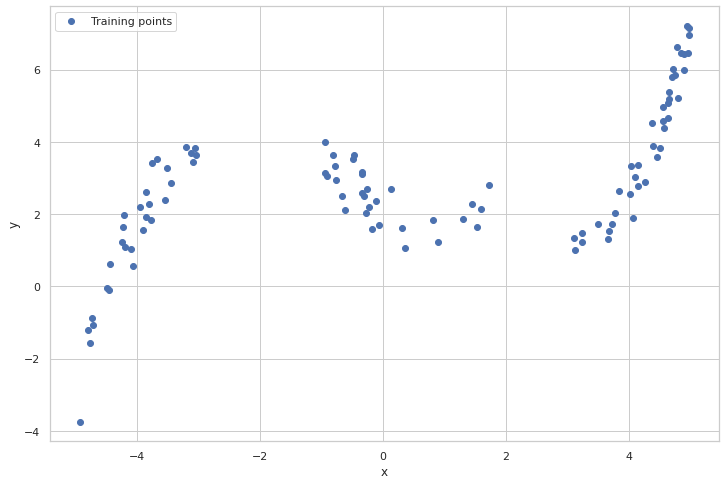

In [7]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
fig.savefig(mydrive+'Train_points.png')
fig.savefig('Train_points.png')

Select GPU

In [8]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


### Create Dataset object & Load Data

In [9]:
class CsvDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    self.df = pd.read_csv(csv_file)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.df)

  def __getitem__(self, idx):
    # Our sample is the element idx of the list self.data
    sample = self.df.iloc[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample

In [10]:
class ToTensor(object):
  def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())

In [11]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('/content/regression_dataset/train_data.csv', transform=composed_transform)
test_dataset  = CsvDataset('/content/regression_dataset/test_data.csv', transform=composed_transform)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

## Define Neural Network

In [14]:
class Net(nn.Module):
  
  def __init__(self, Ni, Nh1, Nh2, Nh3, No, p1, p2, p3):
      """
      Ni - Input size
      Nh1 - Neurons in the 1st hidden layer
      Nh2 - Neurons in the 2nd hidden layer
      No - Output size
      """
      super().__init__()
      
      #print('Network initialized')
      self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
      self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
      self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
      self.out = nn.Linear(in_features=Nh3, out_features=No)
      self.dropout1 = nn.Dropout(p1)
      self.dropout2 = nn.Dropout(p2)
      self.dropout3 = nn.Dropout(p3)
      self.act = nn.ReLU()
      
  def forward(self, x, additional_out=False):
      x = self.act(self.fc1(x))
      x = self.dropout1(x)
      x = self.act(self.fc2(x))
      x = self.dropout2(x)
      x = self.act(self.fc3(x))
      x = self.dropout3(x)
      x = self.out(x)
      return x

### Initialize weights w/ Xavier

In [15]:
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

##Functions

In [ ]:
"""def earlystop(v, patience, epoch):
  best_val=100
  if v < best_val:
    best_val = v
    i = 0
  else:
    i += 1

    if i > patience:
      print("Early stopping at epoch {}".format(epoch))
      break"""

In [ ]:
def train(net, train, valid, epochs, optimizer, loss_fn):
  #early_stopping = EarlyStopping(patience=patience, verbose=True)
  train_loss_log = []
  val_loss_log = []
  best_val=100
  for epoch_num in range(epochs):
    #print(epoch_num)
    train_loss= []
    net.train() 
    for sample_batched in train:
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      out = net(x_batch)
      loss = loss_fn(out, label_batch)
      net.zero_grad()
      loss.backward()
      optimizer.step()
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    train_loss = np.mean(train_loss)
    #print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    val_loss= []
    net.eval()
    with torch.no_grad(): 
      for sample_batched in valid:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        out = net(x_batch)
        loss = loss_fn(out, label_batch)
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)
        
      val_loss = np.mean(val_loss)
      #print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      val_loss_log.append(val_loss)

    """if val_loss < best_val:
      #print(val_loss)
      #print(best_val)
      best_val = val_loss
      i = 0
    else:
      i += 1
      if i > patience:
        print("Early stopping at epoch {}".format(epoch_num))
        break"""

  return train_loss_log, val_loss_log

In [ ]:
"""Ni = 1
Nh1 = 128
Nh2 = 128
Nh3 = 128
No = 1
p1 = 0
p2 = 0
p3 = 0
net = Net(Ni, Nh1, Nh2,Nh3, No,p1,p2, p3 )
net.to(device)
net.apply(init_weights)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2,weight_decay= 0)
t,v,e = train(net,train_dataloader, test_dataset, 1000, optimizer, loss_fn,10)"""

In [ ]:
"""fig = plt.figure(figsize=(12,8))
plt.semilogy(t, label='Train loss')
plt.semilogy(v, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#fig.savefig('loss final reg.png')
#fig.savefig(mydrive+'loss final reg.png')"""

In [ ]:
"""all_inputs = []
all_outputs = []
all_labels = []
net.eval()
with torch.no_grad():
    for sample_batched in test_dataloader:
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      out1 = net(x_batch)
      all_inputs.append(x_batch)
      all_outputs.append(out1)
      all_labels.append(label_batch)

all_inputs  = torch.cat(all_inputs).cpu().numpy()
all_outputs = torch.cat(all_outputs).cpu().numpy()
all_labels  = torch.cat(all_labels).cpu().numpy()

fig = plt.figure(figsize=(12,8))
plt.scatter(all_inputs, all_outputs, label='Predicted points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('y')
plt.ylabel('x')
plt.legend()
plt.show()
#fig.savefig(mydrive+'final_points_reg.png')
#fig.savefig('final_points_reg.png')"""

### KCV

In [29]:
def kcv(nfolds,opt, loss_fn, epochs,Ni,i,j,z,No,p1,p2,p3,l_r,w):
  kf = KFold(n_splits = nfolds, shuffle=True, random_state=42)
  fold =1
  train_l = []
  val_l = []
  for train_index, val_index in kf.split(train_df["input"]):
    net = Net(Ni,i,j,z,No,p1,p2,p3)
    net.apply(init_weights)
    net.to(device)
    opti = opt(net.parameters(), l_r, weight_decay = w)
    Train = torch.utils.data.Subset(train_dataset,train_index)
    Val = torch.utils.data.Subset(train_dataset,val_index)
    train_loader = torch.utils.data.DataLoader(Train, batch_size = len(Train), shuffle = False)
    valid_loader = torch.utils.data.DataLoader(Val, batch_size = len(Val), shuffle = False)
    train_loss, val_loss = train(net, train_loader, valid_loader, epochs, opti, loss_fn)
    train_l.append(train_loss)
    val_l.append(val_loss)
    fold +=1
  t = np.array(train_l)
  v = np.array(val_l)
  return np.mean(t,0), np.mean(v,0), np.std(t,0) , np.std(v,0)

### Grid Search

In [30]:
def GridSearch(Ni, Nh1, Nh2, Nh3, No, optimizer, nfolds , epochs, lr, prob1, prob2, prob3 , weight_dec):
  res = pd.DataFrame(columns=["Nh1","Nh2","Nh3","Optimizer","Epochs", "Learning rate","Prob1","Prob2","Prob3","Weight_dec","Valid_Loss"])
  
  niter = len(Nh1)*len(Nh2)*len(Nh3)*len(optimizer)*len(lr)*len(prob1)*len(prob2)*len(prob3)*len(weight_dec)
  it = 1
  for i in Nh1:
    for j in Nh2:
      for z in Nh3:
        for opt_name, opt in optimizer.items():
          for l_r in lr:
            for p1 in prob1:
              for p2 in prob2:
                for p3 in prob3:
                  for w in weight_dec:
                    print("Nh1 = ", i ,
                          "| Nh2 = ", j , 
                          "| Nh3 = ", z,
                          "| Optimizer = ", opt_name, 
                          "| Lr = ", l_r, 
                          "| p1 = ", p1,
                          "| p2 = ", p2, 
                          "| p3 = ", p3,
                          "| weight_dec = ", w, 
                          "| Iter = ", it,"/", niter)
                    #scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opti,lambda epoch: 0.95, verbose = True)
                    loss_fn = nn.MSELoss()
                    t_l , v_l, _, _= kcv(nfolds,opt, loss_fn, epochs,Ni,i,j,z,No,p1,p2,p3,l_r,w)
                    data = pd.Series({"Nh1" : i,
                                        "Nh2": j,
                                        "Nh3": z,
                                        "Optimizer" : opt_name, 
                                        "Epochs" : e,
                                        "Learning rate": l_r,
                                        "Prob1": p1,
                                        "Prob2": p2,
                                        "Prob3": p3,
                                        "Weight_dec": w,
                                        "Valid_Loss"  : v_l[-1]},
                                    name=it)        
                    res = res.append(data)
                    it +=1
  return res.sort_values("Valid_Loss")

##Train

### First grid search

In [31]:
Ni = 1
Nh1 = list(np.random.randint(50, 250, size=6))
Nh2 = list(np.random.randint(50, 250, size=6))
Nh3 = list(np.random.randint(50, 250, size=6))
No = 1
optimizer = {"Adam":torch.optim.Adam}
l_r = [0.001]
prob1 = [0]
prob2 = [0]
prob3 = [0]
weight_d = [0]
e = 400
results = GridSearch(Ni, Nh1, Nh2 , Nh3, No, optimizer, 5,  e, l_r, prob1, prob2, prob3, weight_d)
results.to_csv(mydrive+"GridSearch1_reg.csv", index=False)

Nh1 =  227 | Nh2 =  224 | Nh3 =  201 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0 | Iter =  1 / 216
Nh1 =  227 | Nh2 =  224 | Nh3 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0 | Iter =  2 / 216
Nh1 =  227 | Nh2 =  224 | Nh3 =  85 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0 | Iter =  3 / 216
Nh1 =  227 | Nh2 =  224 | Nh3 =  202 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0 | Iter =  4 / 216
Nh1 =  227 | Nh2 =  224 | Nh3 =  182 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0 | Iter =  5 / 216
Nh1 =  227 | Nh2 =  224 | Nh3 =  135 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0 | Iter =  6 / 216
Nh1 =  227 | Nh2 =  235 | Nh3 =  201 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0 | Iter =  7 / 216
Nh1 =  227 | Nh2 =  235 | Nh3 =  192 | Opt

In [32]:
head = results.head()
head

,Nh1,Nh2,Nh3,Optimizer,Epochs,Learning rate,Prob1,Prob2,Prob3,Weight_dec,Valid_Loss
116,113,235,192,Adam,400,0.001,0,0,0,0,0.295561
21,227,60,85,Adam,400,0.001,0,0,0,0,0.300488
139,113,176,201,Adam,400,0.001,0,0,0,0,0.301217
104,184,176,192,Adam,400,0.001,0,0,0,0,0.304277
82,184,235,202,Adam,400,0.001,0,0,0,0,0.304711


In [ ]:
#print(head.to_latex(index = True))

In [ ]:
"""best_model = results.loc[results["Valid_Loss"].idxmin()]
best_model"""

'best_model = results.loc[results["Valid_Loss"].idxmin()]\nbest_model'

In [ ]:
#print(best_model.to_latex(index=False))

In [33]:
best_model= pd.read_csv(mydrive+"GridSearch1_reg.csv").loc[0]

### Second grid search

In [34]:
Ni = 1
Nh1 = [best_model["Nh1"]]
Nh2 = [best_model["Nh2"]]
Nh3 = [best_model["Nh3"]]
No = 1
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
l_r = [0.001, 0.005]
prob1 = [0, 0.2]
prob2 = [0, 0.2]
prob3 = [0, 0.2]
weight_d = [0, 1e-3, 1e-5]
e = 400
results = GridSearch(Ni, Nh1, Nh2 , Nh3, No, optimizer, 5,  e, l_r, prob1, prob2, prob3, weight_d)
results.to_csv(mydrive+"GridSearch2_reg.csv", index=False)

Nh1 =  113 | Nh2 =  235 | Nh3 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0 | Iter =  1 / 96
Nh1 =  113 | Nh2 =  235 | Nh3 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  0.001 | Iter =  2 / 96
Nh1 =  113 | Nh2 =  235 | Nh3 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0 | weight_dec =  1e-05 | Iter =  3 / 96
Nh1 =  113 | Nh2 =  235 | Nh3 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0.2 | weight_dec =  0 | Iter =  4 / 96
Nh1 =  113 | Nh2 =  235 | Nh3 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0.2 | weight_dec =  0.001 | Iter =  5 / 96
Nh1 =  113 | Nh2 =  235 | Nh3 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | p3 =  0.2 | weight_dec =  1e-05 | Iter =  6 / 96
Nh1 =  113 | Nh2 =  235 | Nh3 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0.2 | p3 =  0 | weight_dec =  0 | Iter =  7 / 96
Nh1 =  113 | Nh2 =  235 

In [35]:
head = results.head()
head

,Nh1,Nh2,Nh3,Optimizer,Epochs,Learning rate,Prob1,Prob2,Prob3,Weight_dec,Valid_Loss
33,113,235,192,Adam,400,0.005,0,0.2,0,1e-05,0.300792
1,113,235,192,Adam,400,0.001,0,0,0,0,0.311766
32,113,235,192,Adam,400,0.005,0,0.2,0,0.001,0.316462
3,113,235,192,Adam,400,0.001,0,0,0,1e-05,0.320264
30,113,235,192,Adam,400,0.005,0,0,0.2,1e-05,0.320929


In [36]:
best_model = results.loc[results["Valid_Loss"].idxmin()]
best_model

Nh1                   113
Nh2                   235
Nh3                   192
Optimizer            Adam
Epochs                400
Learning rate       0.005
Prob1                   0
Prob2                 0.2
Prob3                   0
Weight_dec          1e-05
Valid_Loss       0.300792
Name: 33, dtype: object

### Get losses plot for best model obtained with KCV

In [37]:
best_model= pd.read_csv(mydrive+"GridSearch2_reg.csv").loc[0]
best_model

Nh1                   113
Nh2                   235
Nh3                   192
Optimizer            Adam
Epochs                400
Learning rate       0.005
Prob1                   0
Prob2                 0.2
Prob3                   0
Weight_dec          1e-05
Valid_Loss       0.300792
Name: 0, dtype: object

In [38]:
pd.read_csv(mydrive+"GridSearch2_reg.csv").head().to_latex(index = False)

'\\begin{tabular}{rrrlrrrrrrr}\n\\toprule\n Nh1 &  Nh2 &  Nh3 & Optimizer &  Epochs &  Learning rate &  Prob1 &  Prob2 &  Prob3 &  Weight\\_dec &  Valid\\_Loss \\\\\n\\midrule\n 113 &  235 &  192 &      Adam &     400 &          0.005 &    0.0 &    0.2 &    0.0 &     0.00001 &    0.300792 \\\\\n 113 &  235 &  192 &      Adam &     400 &          0.001 &    0.0 &    0.0 &    0.0 &     0.00000 &    0.311766 \\\\\n 113 &  235 &  192 &      Adam &     400 &          0.005 &    0.0 &    0.2 &    0.0 &     0.00100 &    0.316462 \\\\\n 113 &  235 &  192 &      Adam &     400 &          0.001 &    0.0 &    0.0 &    0.0 &     0.00001 &    0.320264 \\\\\n 113 &  235 &  192 &      Adam &     400 &          0.005 &    0.0 &    0.0 &    0.2 &     0.00001 &    0.320929 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [39]:
net = Net(1,best_model["Nh1"],best_model["Nh2"],best_model["Nh3"],1, best_model["Prob1"], best_model["Prob2"], best_model["Prob3"])
net.apply(init_weights)
net.to(device)
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
o = optimizer[best_model["Optimizer"]]
#o = o(net.parameters(),best_model["Learning rate"],weight_decay = best_model["Weight_dec"])
t, v, st, sv = kcv(5, o, nn.MSELoss(), best_model["Epochs"],1, best_model["Nh1"],best_model["Nh2"],best_model["Nh3"], 1, best_model["Prob1"], best_model["Prob2"], best_model["Prob3"],best_model["Learning rate"], best_model["Weight_dec"])

In [40]:
v[-1]

0.30956012

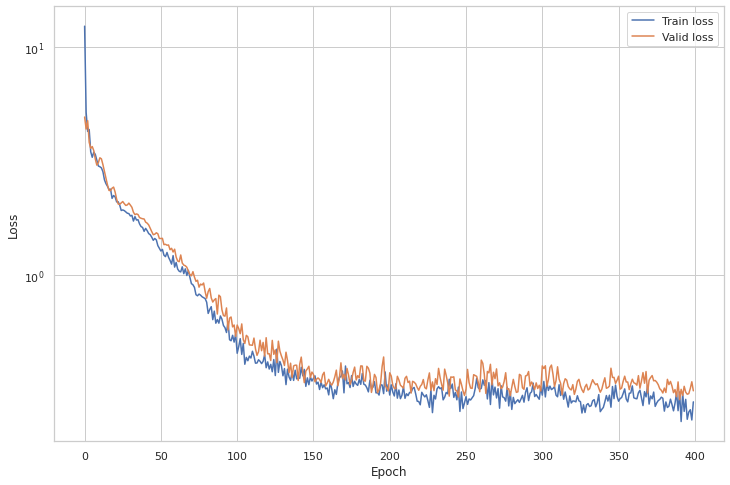

In [41]:
fig = plt.figure(figsize=(12,8))
plt.semilogy(t, label='Train loss')
plt.semilogy(v, label='Valid loss')
#plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='gray', alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('Train KCV.png')
fig.savefig(mydrive+'Train KCV reg.png')

##Final Train

Test Loss = 0.08220968395471573


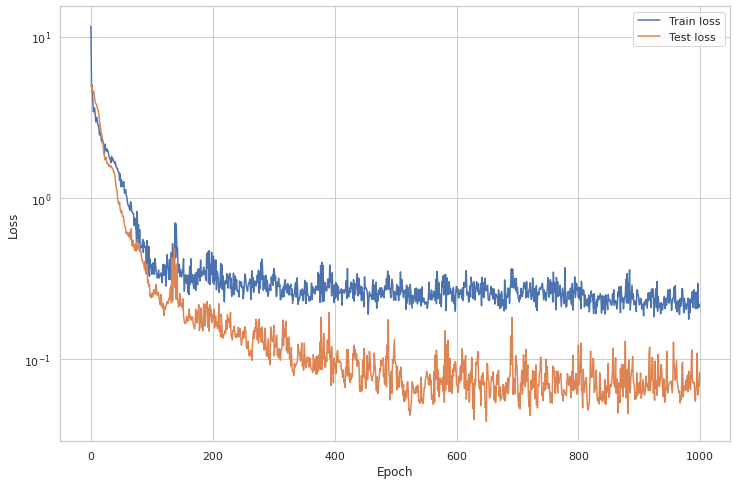

In [42]:
net = Net(1,best_model["Nh1"],best_model["Nh2"],best_model["Nh3"], 1, best_model["Prob1"], best_model["Prob2"], best_model["Prob3"])
net.apply(init_weights)
net.to(device)
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
o = optimizer[best_model["Optimizer"]]
e = 1000
o = o(net.parameters(),best_model["Learning rate"],weight_decay = best_model["Weight_dec"])
t, v = train(net, train_dataloader, test_dataloader, e, o, nn.MSELoss())

print("Test Loss = {}".format(v[-1]))

torch.save(net,mydrive + "net.pt")
torch.save(net.state_dict(),mydrive + "net_state_dict.pt")
torch.save(net,"net.pt")
torch.save(net.state_dict(), "net_state_dict.pt")


fig = plt.figure(figsize=(12,8))
plt.semilogy(t, label='Train loss')
plt.semilogy(v, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss final reg.png')
fig.savefig(mydrive+'loss final reg.png')

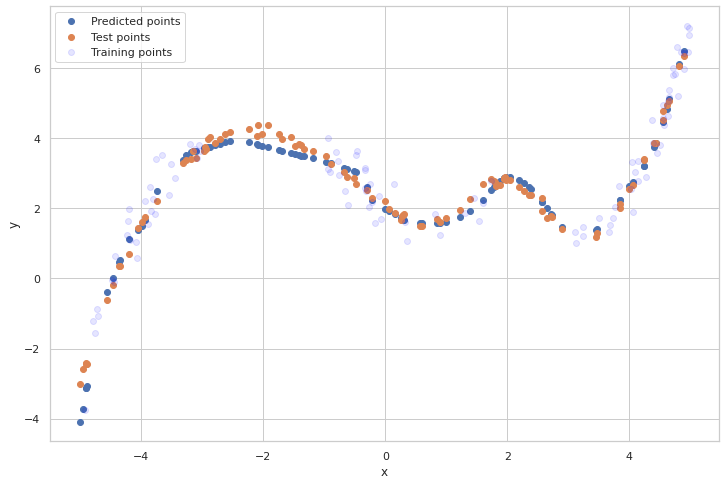

In [43]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval()
with torch.no_grad():
    for sample_batched in test_dataloader:
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      out1 = net(x_batch)
      all_inputs.append(x_batch)
      all_outputs.append(out1)
      all_labels.append(label_batch)

all_inputs  = torch.cat(all_inputs).cpu().numpy()
all_outputs = torch.cat(all_outputs).cpu().numpy()
all_labels  = torch.cat(all_labels).cpu().numpy()

fig = plt.figure(figsize=(12,8))
plt.scatter(all_inputs, all_outputs, label='Predicted points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.scatter(train_df.input, train_df.label, label='Training points',c = 'blue',alpha = 0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
fig.savefig(mydrive+'final_points_reg.png')
fig.savefig('final_points_reg.png')

In [16]:
best_model= pd.read_csv(mydrive+"GridSearch2_reg.csv").loc[0]
net = Net(1,best_model["Nh1"],best_model["Nh2"],best_model["Nh3"], 1, best_model["Prob1"], best_model["Prob2"], best_model["Prob3"])
net.to(device)
net_state_dict = torch.load(mydrive+'net_state_dict.pt')
# Update the network parameters
net.load_state_dict(net_state_dict)

<All keys matched successfully>

##Weights Histogram

In [17]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Third hidden layer
h3_w = net.fc3.weight.data.cpu().numpy()
h3_b = net.fc3.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

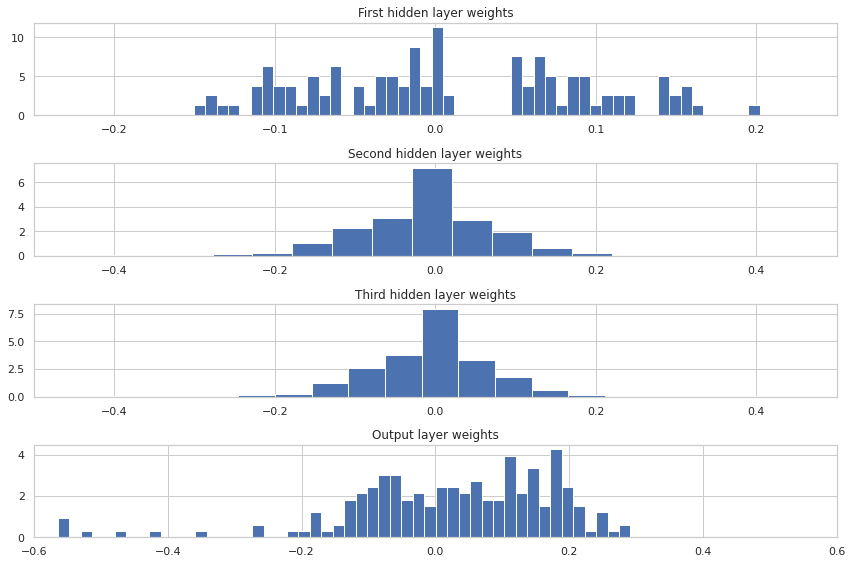

In [17]:
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50, density = True)
axs[0].set_title('First hidden layer weights')
axs[0].set_xlim([-0.25,0.25])
axs[1].hist(h2_w.flatten(), 50, density = True)
axs[1].set_title('Second hidden layer weights')
axs[1].set_xlim([-0.5,0.5])
axs[2].hist(h3_w.flatten(), 50, density = True)
axs[2].set_title('Third hidden layer weights')
axs[2].set_xlim([-0.5,0.5])
axs[3].hist(out_w.flatten(), 50, density = True)
axs[3].set_title('Output layer weights')
axs[3].set_xlim([-0.6,0.6])
plt.tight_layout()
plt.show()
fig.savefig(mydrive+'hist_reg.png')
fig.savefig('hist_reg.png')

##Activation Profile

In [18]:
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(net.fc1.register_forward_hook(hook_fn))
hook_handles.append(net.fc2.register_forward_hook(hook_fn))
hook_handles.append(net.fc3.register_forward_hook(hook_fn))

In [19]:
net_input = train_dataset[1][0]
net_input = net_input.to(device)

In [20]:
net.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = net(net_input)

In [21]:
res = []
for i in range(len(intermediate_outputs)):
  intermediate_output = torch.relu(intermediate_outputs[i]).cpu().data.numpy()
  res.append(intermediate_output)

In [22]:
print(len(res[0]),len(res[1]),len(res[2]))

113 235 192


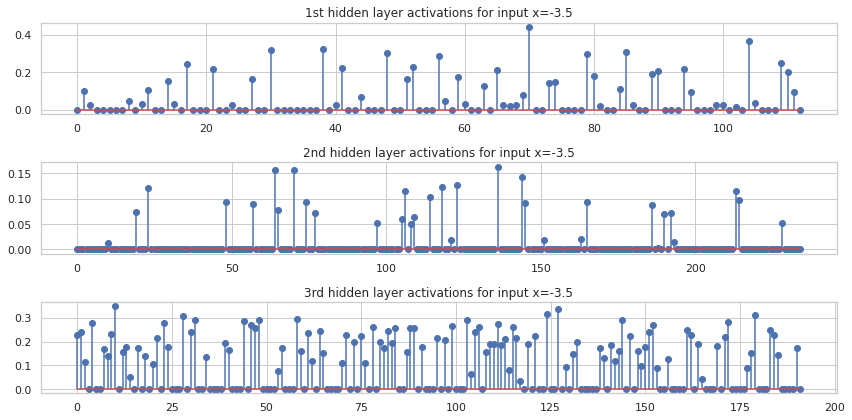

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(12,6))
l = ["1st", "2nd", "3rd"]
for i in range(len(res)):
  axs[i].stem(res[i], use_line_collection=True)
  axs[i].set_title('{} hidden layer activations for input x={:.2}'.format(l[i],net_input.cpu().numpy().squeeze()))
plt.tight_layout()
plt.show()
fig.savefig(mydrive+'act_reg.png')

100


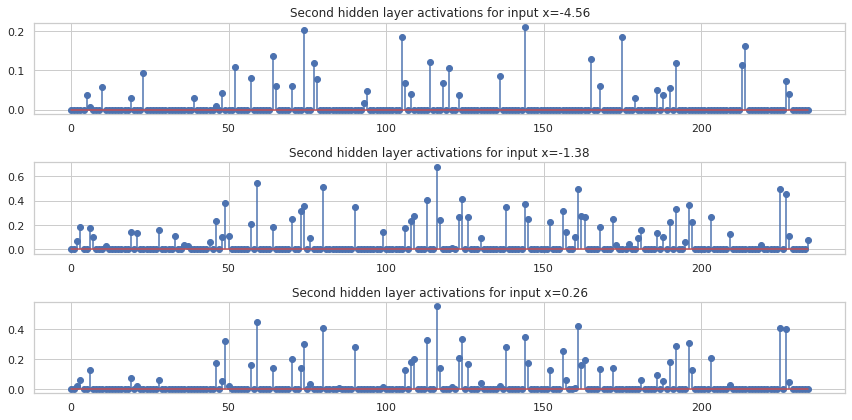

In [54]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

act = []
net.eval()
with torch.no_grad():
    for sample_batched in test_dataloader:
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      out1 = net(x_batch)
      a = activation.cpu().numpy()
      #print(a)
      act.append(a)

print(len(act[0]))
l = random.sample(range(len(act[0])), 3)

### Remove hook
hook_handle.remove()

### Plot activations


fig, axs = plt.subplots(3, 1, figsize=(12,6))
for i in range(len(l)):
  axs[i].stem(act[0][i], use_line_collection=True)
  axs[i].set_title('Second hidden layer activations for input x=%.2f' %all_inputs[l[i]])
plt.tight_layout()
plt.show()
fig.savefig(mydrive+'act_reg.png')

# Classification task: Feed Forward NN

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ShuffleSplit
torch.manual_seed(420)
np.random.seed(420)
torch.backends.cudnn.deterministic = True
random.seed(420)
torch.cuda.manual_seed_all(420)

In [4]:
mydrive = "/content/drive/My Drive/Colab Notebooks/NNDL/HW1/Class/"

## Dataset

In [5]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True,transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True,transform=transforms.ToTensor())

In [6]:
"""train = train_dataset.data.numpy()
test = test_dataset.data.numpy()
#useless for now"""

'train = train_dataset.data.numpy()\ntest = test_dataset.data.numpy()\n#useless for now'

In [7]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


### Load data


In [8]:
rs = ShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, val_index in rs.split(train_dataset):
  Train = torch.utils.data.Subset(train_dataset,train_index)
  Val = torch.utils.data.Subset(train_dataset,val_index)
  train_loader = torch.utils.data.DataLoader(Train, batch_size = len(Train), shuffle = False)
  valid_loader = torch.utils.data.DataLoader(Val, batch_size = len(Val), shuffle = False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)

### Plot training data

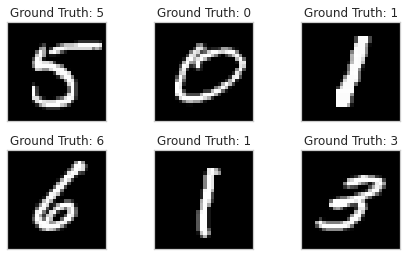

In [9]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.savefig(mydrive+'train_data.png')

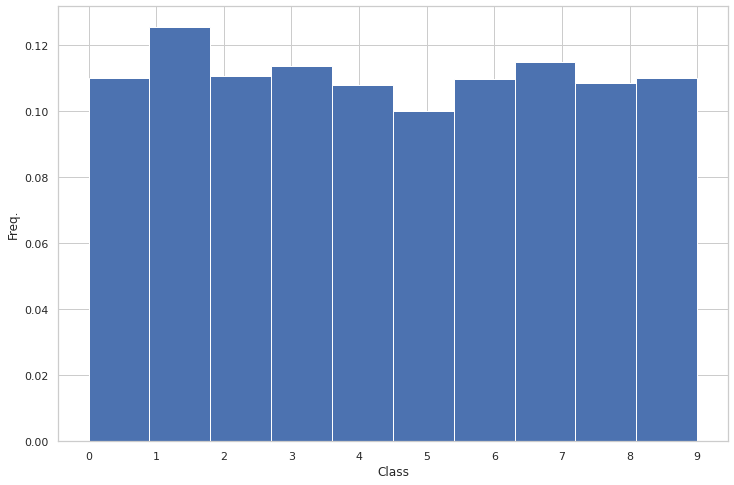

In [10]:
ist = example_targets.cpu().numpy()
fig = plt.figure(figsize=(12,8))
plt.hist(ist, bins= 10,density = True)
plt.xticks(np.arange(10))
plt.xlabel('Class')
plt.ylabel('Freq.')
plt.savefig(mydrive+'hist.png')

## Define Neural Network

In [10]:
class Net(nn.Module):
  def __init__(self, Ni, Nh1, Nh2,No,p1,p2):
    super().__init__()
    self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
    self.fc2 = nn.Linear(Nh1, Nh2)
    self.fc3 = nn.Linear(Nh2, No)
    self.act = nn.ReLU()
    self.dropout1 = nn.Dropout(p1)
    self.dropout2 = nn.Dropout(p2)

  def forward(self, x, additional_out=False):
      x   = self.act(self.fc1(x))
      x   = self.dropout1(x)
      x   = self.act(self.fc2(x))
      x   = self.dropout2(x)
      out = self.fc3(x)
      return out

### Initialize weights

In [11]:
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

## Functions

In [12]:
def train(net, train, valid, epochs, optimizer, loss_fn):
  train_loss_log = []
  val_loss_log = []
  for epoch_num in range(epochs):
    #print(epoch_num)
    train_loss= []
    net.train() 
    for sample_batched in train:
      x_batch = sample_batched[0].reshape(-1, 28*28).to(device)
      label_batch = sample_batched[1].to(device)
      out = net(x_batch)
      loss = loss_fn(out, label_batch)
      net.zero_grad()
      loss.backward()
      optimizer.step()
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    train_loss = np.mean(train_loss)
    #print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    val_loss= []
    net.eval()
    with torch.no_grad(): 
      for sample_batched in valid:
        x_batch = sample_batched[0].reshape(-1, 28*28).to(device)
        label_batch = sample_batched[1].to(device)
        out = net(x_batch)
        loss = loss_fn(out, label_batch)
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)
        
      val_loss = np.mean(val_loss)
      #print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      val_loss_log.append(val_loss)
  return train_loss_log, val_loss_log

### Grid search

In [15]:
def GridSearch(Ni, Nh1, Nh2, No, optimizer, epochs, lr, prob1, prob2, weight_dec):
  res = pd.DataFrame(columns=["Nh1","Nh2","Optimizer","Epochs", "Learning rate","Prob1","Prob2","Weight_dec","Valid_Loss"])
  
  niter = len(Nh1)*len(Nh2)*len(optimizer)*len(lr)*len(prob1)*len(prob2)*len(weight_dec)
  it = 1
  for i in Nh1:
    for j in Nh2:
      for opt_name, opt in optimizer.items():
        for l_r in lr:
          for p1 in prob1:
            for p2 in prob2:
                for w in weight_dec:
                  print("Nh1 = ", i ,
                        "| Nh2 = ", j ,
                        "| Optimizer = ", opt_name, 
                        "| Lr = ", l_r, 
                        "| p1 = ", p1,
                        "| p2 = ", p2,
                        "| weight_dec = ", w, 
                        "| Iter = ", it,"/", niter)
                  net = Net(Ni,i,j,No,p1,p2)
                  net.apply(init_weights)
                  net.to(device)
                  opti = opt(net.parameters(), l_r, weight_decay = w)
                  loss_fn = nn.CrossEntropyLoss()
                  t_l , v_l = train(net,train_loader,valid_loader,epochs,opti,loss_fn)
                  data = pd.Series({"Nh1" : i,
                                      "Nh2": j,
                                      "Optimizer" : opt_name, 
                                      "Epochs" : epochs,
                                      "Learning rate": l_r,
                                      "Prob1": p1,
                                      "Prob2": p2,
                                      "Weight_dec": w,
                                      "Valid_Loss"  : v_l[-1]},
                                  name=it)        
                  res = res.append(data)
                  it +=1
  return res.sort_values("Valid_Loss")

##Train

### First grid search

In [ ]:
Ni = 28*28
np.random.seed(420)
Nh1 = list(np.random.randint(100, 300, size=6))
np.random.seed(42)
Nh2 = list(np.random.randint(100, 300, size=6))
No = 10
optimizer = {"Adam":torch.optim.Adam}
l_r = [0.001]
prob1 = [0]
prob2 = [0]
weight_d = [0]
e = 100
results = GridSearch(Ni, Nh1, Nh2, No, optimizer, e, l_r, prob1, prob2, weight_d)
results.to_csv(mydrive+"GridSearch1_class.csv", index=False)

Nh1 =  277 | Nh2 =  202 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  1 / 36
Nh1 =  277 | Nh2 =  279 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  2 / 36
Nh1 =  277 | Nh2 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  3 / 36
Nh1 =  277 | Nh2 =  114 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  4 / 36
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  5 / 36
Nh1 =  277 | Nh2 =  171 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  6 / 36
Nh1 =  172 | Nh2 =  202 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  7 / 36
Nh1 =  172 | Nh2 =  279 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  8 / 36
Nh1 =  172 | Nh2 =  192 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 

In [ ]:
head = results.head()
head

,Nh1,Nh2,Optimizer,Epochs,Learning rate,Prob1,Prob2,Weight_dec,Valid_Loss
5,277,206,Adam,100,0.001,0,0,0,0.124388
2,277,279,Adam,100,0.001,0,0,0,0.126167
14,234,279,Adam,100,0.001,0,0,0,0.129643
1,277,202,Adam,100,0.001,0,0,0,0.131879
6,277,171,Adam,100,0.001,0,0,0,0.133152


In [ ]:
best_model = pd.read_csv(mydrive+"GridSearch1_class.csv").loc[0]
best_model

Nh1                   277
Nh2                   206
Optimizer            Adam
Epochs                100
Learning rate       0.001
Prob1                   0
Prob2                   0
Weight_dec              0
Valid_Loss       0.124388
Name: 0, dtype: object

### Second grid search

In [ ]:
Ni = 784
Nh1 = [best_model["Nh1"]]
Nh2 = [best_model["Nh2"]]
No = 10
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
l_r = [0.001, 0.005]
prob1 = [0, 0.2]
prob2 = [0, 0.2]
weight_d = [0, 0.1, 0.2]
e = 100
results = GridSearch(Ni, Nh1, Nh2, No, optimizer,  e, l_r, prob1, prob2, weight_d)
results.to_csv(mydrive+"GridSearch2_class.csv", index=False)

Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  1 / 48
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0.1 | Iter =  2 / 48
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0.2 | Iter =  3 / 48
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0.2 | weight_dec =  0 | Iter =  4 / 48
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0.2 | weight_dec =  0.1 | Iter =  5 / 48
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0.2 | weight_dec =  0.2 | Iter =  6 / 48
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0.2 | p2 =  0 | weight_dec =  0 | Iter =  7 / 48
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0.2 | p2 =  0 | weight_dec =  0.1 | Iter =  8 / 48
Nh1 =  277 | Nh2 =  206 | Optimizer =  Adam | Lr =  0.001 | p1 =  0.2 | p2 =

In [ ]:
head = results.head()
head

,Nh1,Nh2,Optimizer,Epochs,Learning rate,Prob1,Prob2,Weight_dec,Valid_Loss
19,277,206,Adam,100,0.005,0.2,0,0,0.078285
16,277,206,Adam,100,0.005,0,0.2,0,0.078528
22,277,206,Adam,100,0.005,0.2,0.2,0,0.080916
13,277,206,Adam,100,0.005,0,0,0,0.088353
37,277,206,RMSprop,100,0.005,0,0,0,0.124858


In [17]:
best_model= pd.read_csv(mydrive+"GridSearch2_class.csv").loc[0]
best_model

Nh1                    277
Nh2                    206
Optimizer             Adam
Epochs                 100
Learning rate        0.005
Prob1                  0.2
Prob2                    0
Weight_dec               0
Valid_Loss       0.0782847
Name: 0, dtype: object

In [16]:
pd.read_csv(mydrive+"GridSearch2_class.csv").head().to_latex(index=False)

'\\begin{tabular}{rrlrrrrrr}\n\\toprule\n Nh1 &  Nh2 & Optimizer &  Epochs &  Learning rate &  Prob1 &  Prob2 &  Weight\\_dec &  Valid\\_Loss \\\\\n\\midrule\n 277 &  206 &      Adam &     100 &          0.005 &    0.2 &    0.0 &         0.0 &    0.078285 \\\\\n 277 &  206 &      Adam &     100 &          0.005 &    0.0 &    0.2 &         0.0 &    0.078528 \\\\\n 277 &  206 &      Adam &     100 &          0.005 &    0.2 &    0.2 &         0.0 &    0.080916 \\\\\n 277 &  206 &      Adam &     100 &          0.005 &    0.0 &    0.0 &         0.0 &    0.088353 \\\\\n 277 &  206 &   RMSprop &     100 &          0.005 &    0.0 &    0.0 &         0.0 &    0.124858 \\\\\n\\bottomrule\n\\end{tabular}\n'

### Get losses plot for best model

In [ ]:
net = Net(784,best_model["Nh1"],best_model["Nh2"],10, best_model["Prob1"], best_model["Prob2"])
net.apply(init_weights)
net.to(device)
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
o = optimizer[best_model["Optimizer"]]
loss_fn = nn.CrossEntropyLoss()
o = o(net.parameters(),best_model["Learning rate"],weight_decay = best_model["Weight_dec"])
t, v = train(net,train_loader,valid_loader, 100 , o ,loss_fn)

In [ ]:
print("Validation loss:",v[-1])

Validation loss: 0.07971373


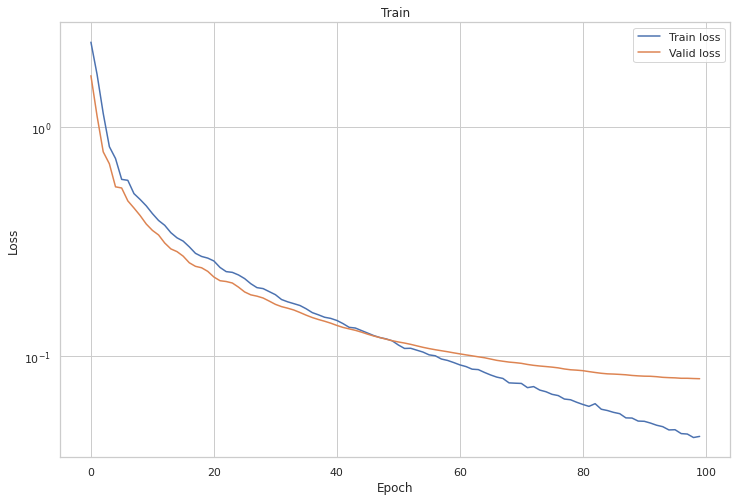

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.semilogy(t, label='Train loss')
plt.semilogy(v, label='Valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train")
plt.legend()
plt.show()
fig.savefig('Train KCV.png')
fig.savefig(mydrive+'Train KCV class.png')

## Final train

Test Loss = 0.07689163833856583


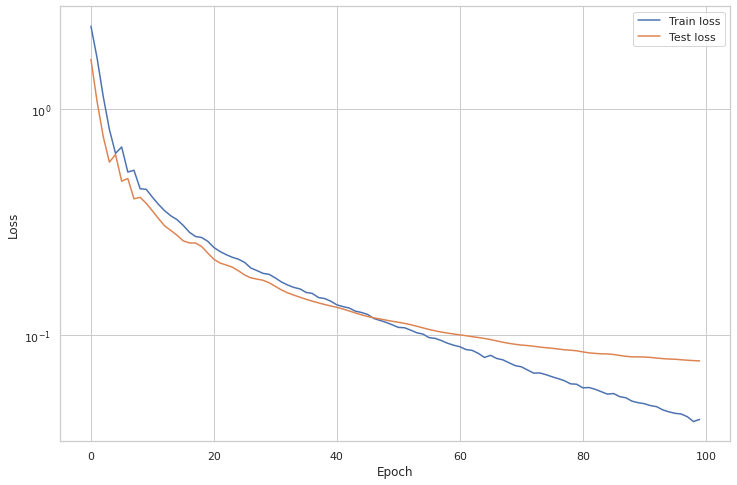

In [18]:
net = Net(784,best_model["Nh1"],best_model["Nh2"], 10, best_model["Prob1"], best_model["Prob2"])
net.apply(init_weights)
net.to(device)
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
o = optimizer[best_model["Optimizer"]]
e = 100
o = o(net.parameters(),best_model["Learning rate"],weight_decay = best_model["Weight_dec"])
t, v = train(net, train_loader, test_loader, e, o, nn.CrossEntropyLoss())

print("Test Loss = {}".format(v[-1]))

fig = plt.figure(figsize=(12,8))
plt.semilogy(t, label='Train loss')
plt.semilogy(v, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss final class.png')
fig.savefig(mydrive+'loss final class.png')

In [19]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval()
with torch.no_grad():
    for sample_batched in test_loader:
      x_batch = sample_batched[0].reshape(-1, 28*28).to(device)
      label_batch = sample_batched[1].to(device)
      out = net(x_batch)
      all_inputs.append(x_batch)
      all_outputs.append(out)
      all_labels.append(label_batch)

#all_inputs  = torch.cat(all_inputs).cpu().numpy()
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels).cpu().numpy()
all_outputs = F.log_softmax(all_outputs, dim=1)

_, y_class = all_outputs.max(1)
np_Y_test = all_labels
np_y_pred = y_class.cpu().numpy()
correct = np.sum(np_Y_test == np_y_pred)
print("Accuracy = {:.3f} %".format(correct*100/np_Y_test.shape[0]))

Accuracy = 97.680 %


##Counfusion Matrix

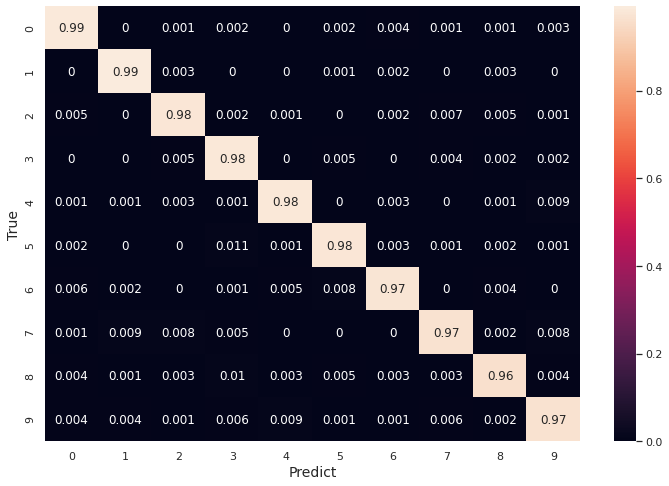

In [20]:
# confusion matrix (normalized over rows, e.g. true labels)
confusion = confusion_matrix(np_Y_test, np_y_pred, normalize="true")
df_confusion = pd.DataFrame(confusion, index = [i for i in range(10)], columns = [i for i in range(10)])
df_confusion = df_confusion.round(3)
# plot entire confusion matrix
plt.figure(figsize = (12,8))
sns.heatmap(df_confusion, annot=True)
plt.xlabel("Predict", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.savefig(mydrive+"Confusion_complete.png")
plt.show()

In [13]:
best_model= pd.read_csv(mydrive+"GridSearch2_class.csv").loc[0]
net = Net(28*28,best_model["Nh1"],best_model["Nh2"], 10, best_model["Prob1"], best_model["Prob2"])
net.to(device)
net_state_dict = torch.load(mydrive+'net_state_dict.pt')
# Update the network parameters
net.load_state_dict(net_state_dict)

<All keys matched successfully>

##Histograms

In [ ]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.fc3.weight.data.cpu().numpy()
out_b = net.fc3.bias.data.cpu().numpy()

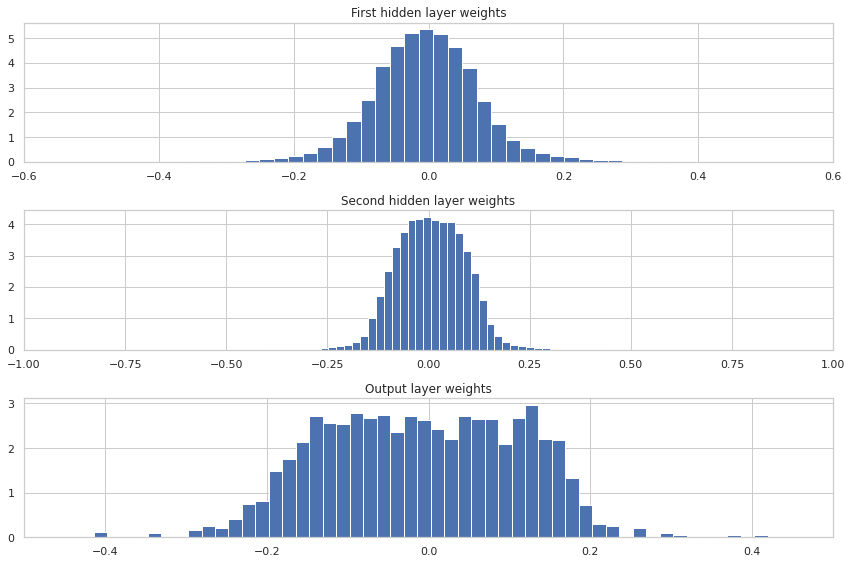

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50, density = True)
axs[0].set_title('First hidden layer weights')
axs[0].set_xlim([-0.6,0.6])
axs[1].hist(h2_w.flatten(), 50, density = True)
axs[1].set_title('Second hidden layer weights')
axs[1].set_xlim([-1,1])
axs[2].hist(out_w.flatten(), 50, density = True)
axs[2].set_title('Output layer weights')
axs[2].set_xlim([-0.5,0.5])
plt.tight_layout()
plt.show()
fig.savefig(mydrive+'hist_reg.png')
fig.savefig('hist_reg.png')

## Activation Profile


In [14]:
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(net.fc1.register_forward_hook(hook_fn))
hook_handles.append(net.fc2.register_forward_hook(hook_fn))

In [15]:
net_input = train_dataset[1][0].reshape(-1, 28*28)
net_input = net_input.to(device)

In [16]:
net.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = net(net_input)

'net.eval()\nwith torch.no_grad():\n    for sample_batched in test_loader:\n      x_batch = sample_batched[0].reshape(-1, 28*28).to(device)\n      label_batch = sample_batched[1].to(device)\n      out = net(x_batch)\n      all_inputs.append(x_batch)\n      all_outputs.append(out)\n      all_labels.append(label_batch)'

In [18]:
res = []
for i in range(len(intermediate_outputs)):
  intermediate_output = torch.relu(intermediate_outputs[i]).cpu().data.numpy()
  res.append(intermediate_output.squeeze())

In [22]:
print(len(res[0]),len(res[1]))

277 206


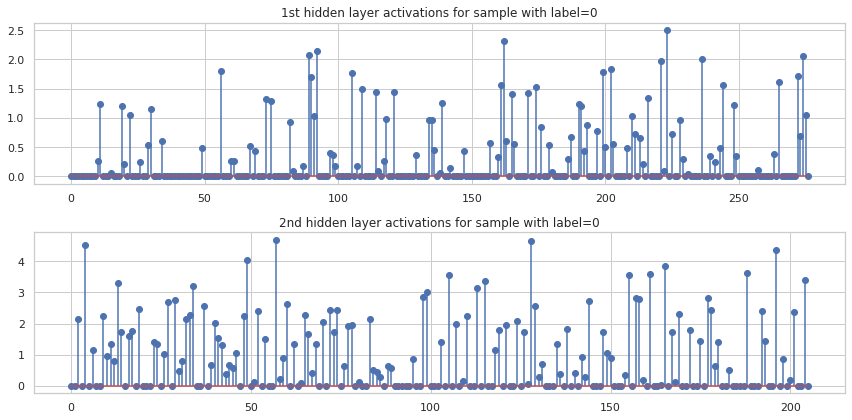

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(12,6))
l = ["1st", "2nd"]
for i in range(len(res)):
  axs[i].stem(res[i], use_line_collection=True)
  axs[i].set_title('{} hidden layer activations for sample with label={}'.format(l[i],train_dataset[1][1]))
plt.tight_layout()
plt.show()
fig.savefig(mydrive+'act_reg.png')

In [31]:
# Remove the hooks using the handles saved during the hooks definition
for handle in hook_handles:
  handle.remove()

#Classification task: CNN

In [32]:
mydrive = "/content/drive/My Drive/Colab Notebooks/NNDL/HW1/CNN/"

In [33]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


## Dataset

In [34]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True,transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True,transform=transforms.ToTensor())

### Plot training data

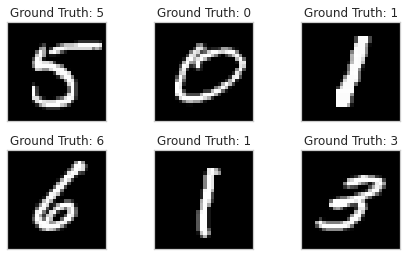

In [37]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.savefig(mydrive+'train_data.png')

### Load data

In [35]:
rs = ShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, val_index in rs.split(train_dataset):
  Train = torch.utils.data.Subset(train_dataset,train_index)
  Val = torch.utils.data.Subset(train_dataset,val_index)
  train_loader = torch.utils.data.DataLoader(Train, batch_size = len(Train), shuffle = False)
  valid_loader = torch.utils.data.DataLoader(Val, batch_size = len(Val), shuffle = False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)

## Define CNN

In [36]:
class Net(nn.Module):
    def __init__(self,Nh1, Nh2, p1, p2):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels = 6, kernel_size= 5, stride =1, padding=1)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels= 12, kernel_size= 3, stride =1, padding=2)
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride =2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride =2)
        self.conv2_drop1 = nn.Dropout2d(p1)
        self.conv2_drop2 = nn.Dropout2d(p2)

        self.act = nn.ReLU()

        self.flatten = nn.Flatten(start_dim=1)

        self.lin = nn.Sequential(
          nn.Linear(12*6*6, Nh1),
          nn.ReLU(),
          nn.Linear(Nh1, Nh2),
          nn.ReLU(),
          nn.Linear(Nh2,10)
        )
        
    def forward(self, x):
      x = self.act(self.conv1(x))
      x = self.conv2_drop1(x)
      x = self.avgpool(x)
      x = self.act(self.conv2(x))
      x = self.conv2_drop2(x)
      x = self.maxpool(x)
      x = self.flatten(x)
      x = self.lin(x)
      return x

sample = next(iter(valid_loader))
sample = sample[0]
print(sample.shape)

net = Net(100,200,0,0)
out = net(sample)
print(out.shape)

torch.Size([12000, 1, 28, 28])
torch.Size([12000, 10])


### Initialize weights

In [38]:
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

## Functions

In [39]:
def train(net, train, valid, epochs, optimizer, loss_fn):
  train_loss_log = []
  val_loss_log = []
  for epoch_num in range(epochs):
    #print(epoch_num)
    train_loss= []
    net.train() 
    for sample_batched in train:
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      out = net(x_batch)
      loss = loss_fn(out, label_batch)
      net.zero_grad()
      loss.backward()
      optimizer.step()
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    train_loss = np.mean(train_loss)
    #print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    val_loss= []
    net.eval()
    with torch.no_grad(): 
      for sample_batched in valid:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        out = net(x_batch)
        loss = loss_fn(out, label_batch)
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)
        
      val_loss = np.mean(val_loss)
      #print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      val_loss_log.append(val_loss)
  return train_loss_log, val_loss_log

### Grid search

In [40]:
def GridSearch(Nh1, Nh2, optimizer, epochs, lr, prob1, prob2, weight_dec):
  res = pd.DataFrame(columns=["Nh1","Nh2","Optimizer","Epochs", "Learning rate","Prob1","Prob2","Weight_dec","Valid_Loss"])
  
  niter = len(Nh1)*len(Nh2)*len(optimizer)*len(lr)*len(prob1)*len(prob2)*len(weight_dec)
  it = 1
  for i in Nh1:
    for j in Nh2:
      for opt_name, opt in optimizer.items():
        for l_r in lr:
          for p1 in prob1:
            for p2 in prob2:
                for w in weight_dec:
                  print("Nh1 = ", i ,
                        "| Nh2 = ", j ,
                        "| Optimizer = ", opt_name, 
                        "| Lr = ", l_r, 
                        "| p1 = ", p1,
                        "| p2 = ", p2,
                        "| weight_dec = ", w, 
                        "| Iter = ", it,"/", niter)
                  net = Net(i,j,p1,p2)
                  net.apply(init_weights)
                  net.to(device)
                  opti = opt(net.parameters(), l_r, weight_decay = w)
                  loss_fn = nn.CrossEntropyLoss()
                  t_l , v_l = train(net,train_loader,valid_loader,epochs,opti,loss_fn)
                  data = pd.Series({"Nh1" : i,
                                      "Nh2": j,
                                      "Optimizer" : opt_name, 
                                      "Epochs" : epochs,
                                      "Learning rate": l_r,
                                      "Prob1": p1,
                                      "Prob2": p2,
                                      "Weight_dec": w,
                                      "Valid_Loss"  : v_l[-1]},
                                  name=it)        
                  res = res.append(data)
                  it +=1
  return res.sort_values("Valid_Loss")

## Train

### First grid search

In [ ]:
np.random.seed(420)
Nh1 = list(np.random.randint(50, 300, size=6))
np.random.seed(42)
Nh2 = list(np.random.randint(50, 300, size=6))
optimizer = {"Adam":torch.optim.Adam}
l_r = [0.001]
prob1 = [0]
prob2 = [0]
weight_d = [0]
e = 50
results = GridSearch(Nh1, Nh2, optimizer, e, l_r, prob1, prob2, weight_d)
results.to_csv(mydrive+"GridSearch1_CNN.csv", index=False)

In [ ]:
head = results.head()
head

In [41]:
best_model = pd.read_csv(mydrive+"GridSearch1_CNN.csv").loc[0]
best_model

Nh1                   227
Nh2                   121
Optimizer            Adam
Epochs                 50
Learning rate       0.001
Prob1                   0
Prob2                   0
Weight_dec              0
Valid_Loss       0.231129
Name: 0, dtype: object

###Second grid search

In [42]:
Nh1 = [best_model["Nh1"]]
Nh2 = [best_model["Nh2"]]
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
l_r = [0.001, 0.005]
prob1 = [0, 0.2]
prob2 = [0, 0.2]
weight_d = [0, 1e-3, 1e-5]
e = 50
results = GridSearch(Nh1, Nh2, optimizer,  e, l_r, prob1, prob2, weight_d)
results.to_csv(mydrive+"GridSearch2_CNN.csv", index=False)

Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0 | Iter =  1 / 48
Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  0.001 | Iter =  2 / 48
Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0 | weight_dec =  1e-05 | Iter =  3 / 48
Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0.2 | weight_dec =  0 | Iter =  4 / 48
Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0.2 | weight_dec =  0.001 | Iter =  5 / 48
Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  0 | p2 =  0.2 | weight_dec =  1e-05 | Iter =  6 / 48
Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  0.2 | p2 =  0 | weight_dec =  0 | Iter =  7 / 48
Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  0.2 | p2 =  0 | weight_dec =  0.001 | Iter =  8 / 48
Nh1 =  227 | Nh2 =  121 | Optimizer =  Adam | Lr =  0.001 | p1 =  

In [43]:
head = results.head()
head

,Nh1,Nh2,Optimizer,Epochs,Learning rate,Prob1,Prob2,Weight_dec,Valid_Loss
18,227,121,Adam,50,0.005,0,0.2,1e-05,0.116622
24,227,121,Adam,50,0.005,0.2,0.2,1e-05,0.120570
16,227,121,Adam,50,0.005,0,0.2,0,0.124629
13,227,121,Adam,50,0.005,0,0,0,0.126308
15,227,121,Adam,50,0.005,0,0,1e-05,0.127253


In [44]:
f = pd.read_csv(mydrive+"GridSearch2_CNN.csv").head().to_latex(index = False)
f

'\\begin{tabular}{rrlrrrrrr}\n\\toprule\n Nh1 &  Nh2 & Optimizer &  Epochs &  Learning rate &  Prob1 &  Prob2 &  Weight\\_dec &  Valid\\_Loss \\\\\n\\midrule\n 227 &  121 &      Adam &      50 &          0.005 &    0.0 &    0.2 &     0.00001 &    0.116622 \\\\\n 227 &  121 &      Adam &      50 &          0.005 &    0.2 &    0.2 &     0.00001 &    0.120570 \\\\\n 227 &  121 &      Adam &      50 &          0.005 &    0.0 &    0.2 &     0.00000 &    0.124629 \\\\\n 227 &  121 &      Adam &      50 &          0.005 &    0.0 &    0.0 &     0.00000 &    0.126308 \\\\\n 227 &  121 &      Adam &      50 &          0.005 &    0.0 &    0.0 &     0.00001 &    0.127253 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [45]:
best_model= pd.read_csv(mydrive+"GridSearch2_CNN.csv").loc[0]
best_model

Nh1                   227
Nh2                   121
Optimizer            Adam
Epochs                 50
Learning rate       0.005
Prob1                   0
Prob2                 0.2
Weight_dec          1e-05
Valid_Loss       0.116622
Name: 0, dtype: object

### Get losses plot for best model

In [46]:
net = Net(best_model["Nh1"],best_model["Nh2"],best_model["Prob1"], best_model["Prob2"])
net.apply(init_weights)
net.to(device)
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
o = optimizer[best_model["Optimizer"]]
loss_fn = nn.CrossEntropyLoss()
o = o(net.parameters(),best_model["Learning rate"],weight_decay = best_model["Weight_dec"])
t, v = train(net,train_loader,valid_loader, e , o ,loss_fn)

In [47]:
print("Validation loss:",v[-1])

Validation loss: 0.118441224


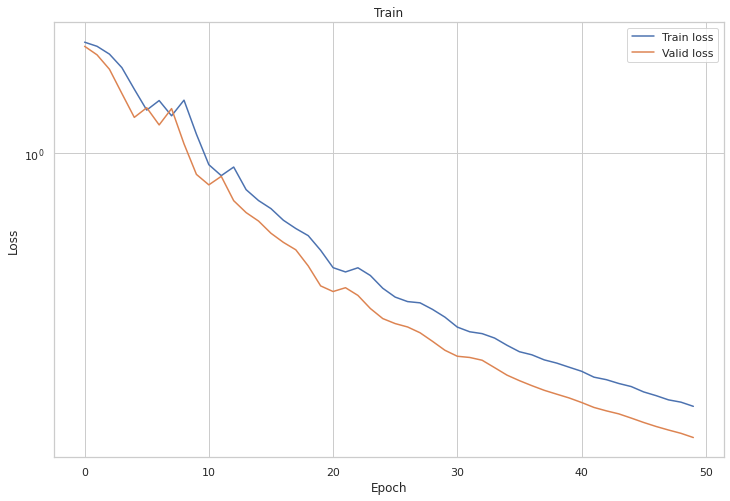

In [48]:
fig = plt.figure(figsize=(12,8))
plt.semilogy(t, label='Train loss')
plt.semilogy(v, label='Valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train")
plt.legend()
plt.show()
fig.savefig('Train CNN.png')
fig.savefig(mydrive+'Train CNN.png')

## Final train

In [49]:
net = Net(best_model["Nh1"],best_model["Nh2"],best_model["Prob1"], best_model["Prob2"])
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (avgpool): AvgPool2d(kernel_size=3, stride=2, padding=0)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop1): Dropout2d(p=0.0, inplace=False)
  (conv2_drop2): Dropout2d(p=0.2, inplace=False)
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=432, out_features=227, bias=True)
    (1): ReLU()
    (2): Linear(in_features=227, out_features=121, bias=True)
    (3): ReLU()
    (4): Linear(in_features=121, out_features=10, bias=True)
  )
)

Test Loss = 0.032538339495658875


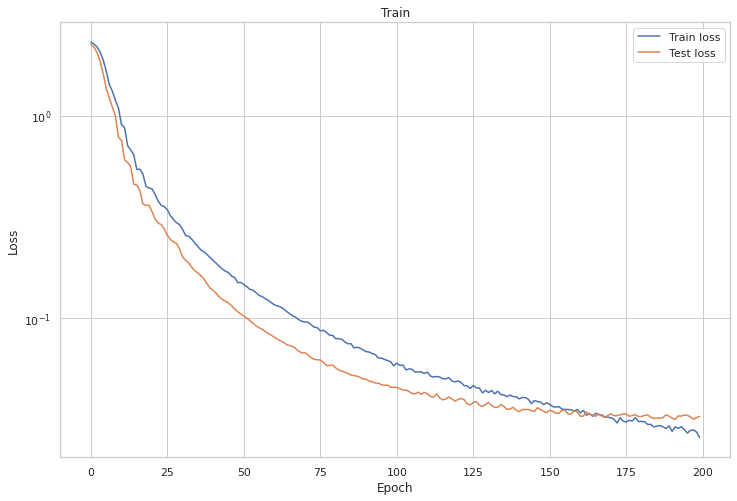

In [50]:
net = Net(best_model["Nh1"],best_model["Nh2"],best_model["Prob1"], best_model["Prob2"])

net.apply(init_weights)
net.to(device)
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}
o = optimizer[best_model["Optimizer"]]

e = 200
o = o(net.parameters(),best_model["Learning rate"],weight_decay = best_model["Weight_dec"])

t, v = train(net, train_loader, test_loader, e, o, nn.CrossEntropyLoss())

print("Test Loss = {}".format(v[-1]))

torch.save(net,mydrive + "net.pt")
torch.save(net.state_dict(),mydrive + "net_state_dict.pt")
torch.save(net,"net.pt")
torch.save(net.state_dict(), "net_state_dict.pt")


fig = plt.figure(figsize=(12,8))
plt.semilogy(t, label='Train loss')
plt.semilogy(v, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train')
plt.legend()
plt.show()
fig.savefig(mydrive+'loss final CNN.png')

In [51]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval()
with torch.no_grad():
    for sample_batched in test_loader:
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      out = net(x_batch)
      all_inputs.append(x_batch)
      all_outputs.append(out)
      all_labels.append(label_batch)

#all_inputs  = torch.cat(all_inputs).cpu().numpy()
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels).cpu().numpy()
all_outputs = F.log_softmax(all_outputs, dim=1)

_, y_class = all_outputs.max(1)
np_Y_test = all_labels
np_y_pred = y_class.cpu().numpy()
correct = np.sum(np_Y_test == np_y_pred)
print("Accuracy = {:.3f} %".format(correct*100/np_Y_test.shape[0]))

Accuracy = 99.000 %


## Confusion matrix

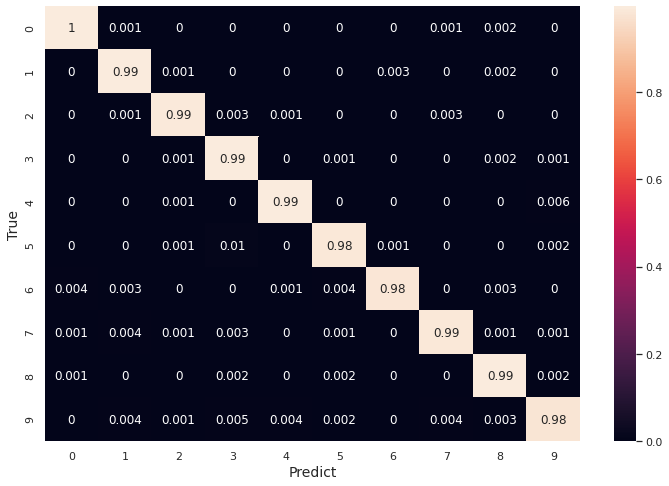

In [52]:
# confusion matrix (normalized over rows, e.g. true labels)
confusion = confusion_matrix(np_Y_test, np_y_pred, normalize="true")
df_confusion = pd.DataFrame(confusion, index = [i for i in range(10)], columns = [i for i in range(10)])
df_confusion = df_confusion.round(3)
# plot entire confusion matrix
plt.figure(figsize = (12,8))
sns.heatmap(df_confusion, annot=True)
plt.xlabel("Predict", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.savefig(mydrive+"Confusion_completecnn.png")
plt.show()

In [53]:
best_model= pd.read_csv(mydrive+"GridSearch2_CNN.csv").loc[0]
net = Net(best_model["Nh1"],best_model["Nh2"], best_model["Prob1"], best_model["Prob2"])
net.to(device)
net_state_dict = torch.load(mydrive+'net_state_dict.pt')
# Update the network parameters
net.load_state_dict(net_state_dict)

<All keys matched successfully>

##Weights

In [54]:
weights_l1 = net.conv1.weight.data.cpu().numpy()
weights_l2 = net.conv2.weight.data.cpu().numpy()

In [55]:
shape=weights_l2.shape
shape

(12, 6, 3, 3)

In [56]:
weights_l2.reshape(shape[0]*shape[1], shape[2], shape[3])

array([[[-2.32608826e-07,  2.28808108e-06, -4.57377922e-07],
        [-2.14794738e-07,  2.67479322e-06, -1.67954920e-06],
        [ 5.70308259e-07, -2.13041244e-06, -1.15845819e-06]],

       [[-1.93895676e-06, -7.72472276e-07, -2.24278267e-07],
        [-2.07717221e-06, -2.24399696e-06, -3.84215491e-06],
        [-2.58971198e-07,  8.81917401e-07,  1.36746587e-06]],

       [[ 1.33243213e-06, -5.81666995e-07,  2.47929620e-06],
        [-2.72609554e-06, -2.49691016e-06,  1.31274714e-06],
        [ 1.81945018e-06, -1.59452009e-06, -6.15346039e-07]],

       [[ 1.11538668e-06,  3.46981437e-06, -1.63192635e-06],
        [ 1.08069605e-06,  1.45514048e-06, -4.52137705e-08],
        [-2.26845913e-07, -2.52589689e-06, -3.43161832e-06]],

       [[ 2.42634741e-07, -2.40853160e-06, -1.68925874e-06],
        [ 8.43815428e-07,  1.68199540e-06, -1.10497034e-08],
        [-3.75122659e-06, -1.35411005e-06, -1.41108126e-06]],

       [[ 4.61242234e-06,  1.88758250e-07,  1.47500418e-06],
        [-5.73

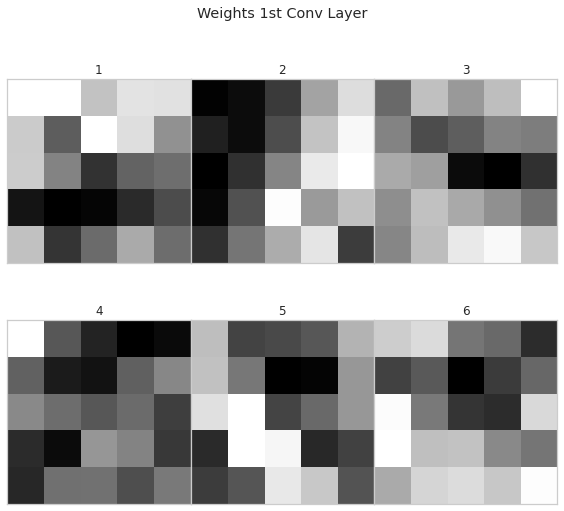

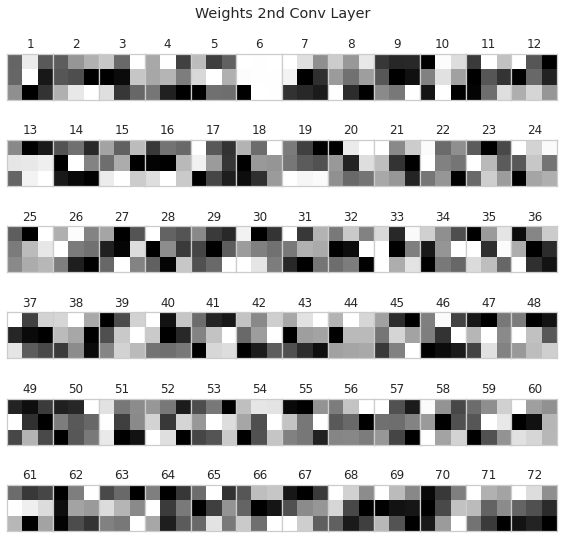

In [57]:
def plot_nchw_data(data, h_num, v_num, title):
    fig, axs = plt.subplots(h_num, v_num, figsize=(8,8))
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(idx+1)
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    fig.savefig(mydrive+title+".png")

plot_nchw_data(weights_l1, 2, 3, 'Weights 1st Conv Layer')
plot_nchw_data(weights_l2, 6, 12, 'Weights 2nd Conv Layer')

## Activation profile

In [58]:
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(net.conv1.register_forward_hook(hook_fn))
hook_handles.append(net.conv2.register_forward_hook(hook_fn))

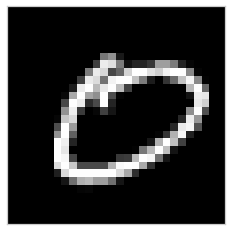

In [59]:
# Define input
net_input = example_data[1][0].unsqueeze(0)
net_input = net_input.to(device)

# Show original image
plt.imshow(example_data[1][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

In [60]:
# Evaluate output
net.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = net(net_input.unsqueeze(0))

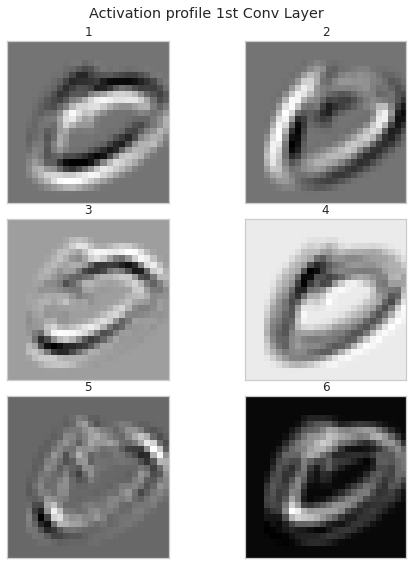

In [61]:
intermediate_output = intermediate_outputs[0].cpu().data.numpy()
plot_nchw_data(intermediate_output, 3, 2, 'Activation profile 1st Conv Layer')

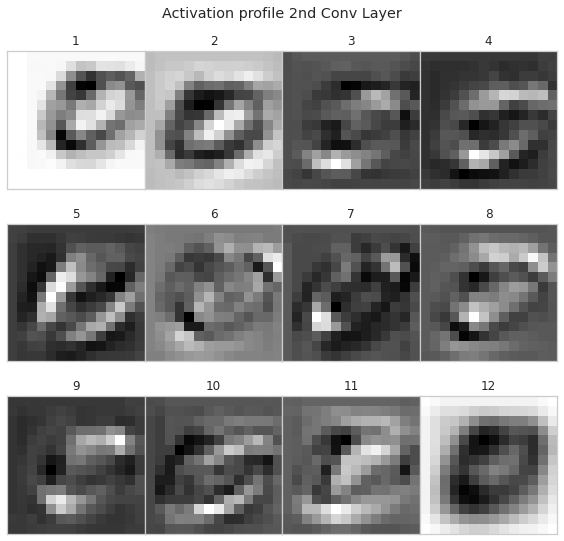

In [62]:
intermediate_output = intermediate_outputs[1].cpu().data.numpy()
plot_nchw_data(intermediate_output, 3, 4, 'Activation profile 2nd Conv Layer')

In [63]:
# Remove the hooks using the handles saved during the hooks definition
for handle in hook_handles:
  handle.remove()